<a href="https://colab.research.google.com/github/quyongkeomut/Project-Machine-learning-UEH-/blob/main/Source.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#A. Khai báo thư viện và biến toàn cục

In [1]:
from google.colab import drive
drive.mount('/content/drive')

import os

import math

import warnings
warnings.filterwarnings('ignore')

from collections import Counter

import numpy as np

import pandas as pd

#!pip install pygwalker
#import pygwalker as pyg

import seaborn as sns
sns.set_style('whitegrid')

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.decomposition import PCA #decomposition
#models
from sklearn.ensemble import RandomForestClassifier #model 1
from sklearn.linear_model import LogisticRegression #model 2
from sklearn.svm import SVC #model 3

from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import recall_score, accuracy_score, log_loss

#for saving model
import pickle

#dnn
import keras
import keras.callbacks

Mounted at /content/drive


In [2]:
SEED = 42
keras.utils.set_random_seed(SEED)
FIG_SIZE=(12, 9)

In [3]:
def scatter_plot(df,
                 pairs,
                 hue,
                 fig_size=FIG_SIZE):

    plt.figure(figsize=fig_size)
    num_col = len(pairs)
    for i, pair in enumerate(pairs, 1):
        plt.subplot(math.ceil(num_col/2), 2, i)
        sns.scatterplot(x=df[pair[0]],
                        y=df[pair[1]],
                        hue=df[hue])
        plt.title(f"Biểu đồ phân tán giữa hai thuộc tính {pair[0]} và {pair[1]}")
        '''if col == "Departure Delay in Minutes":
            plt.ylim(0, 1000)'''
        plt.tight_layout()
        plt.plot()

def histogram(df,
              hue,
              fig_size=FIG_SIZE):
    plt.figure(figsize=fig_size)
    num_col = df.iloc[:, :-1].shape[1]
    for i, col in enumerate(df.iloc[:, :-1], 1):
        plt.subplot(math.ceil(num_col/2), 2, i)
        sns.histplot(x=df[col],
                     hue=df[hue],
                     multiple="dodge",)
        plt.title(f"Phân phối của thuộc tính {col}")
        if col == "Departure Delay in Minutes":
            plt.ylim(0, 1000)
        plt.tight_layout()
        plt.plot()

# B. Nạp bộ dữ liệu

In [4]:
# Đường dẫn tới file CSV
train_path = "/content/drive/MyDrive/Đồ án Học máy/Mã nguồn/Bộ dữ liệu/train.csv"
test_path = "/content/drive/MyDrive/Đồ án Học máy/Mã nguồn/Bộ dữ liệu/test.csv"

# Đọc dữ liệu từ file CSV vào DataFrame
train_df = pd.read_csv(train_path, index_col=0)
test_df = pd.read_csv(test_path, index_col=0)
train_df.columns

Index(['id', 'Gender', 'Customer Type', 'Age', 'Type of Travel', 'Class',
       'Flight Distance', 'Inflight wifi service',
       'Departure/Arrival time convenient', 'Ease of Online booking',
       'Gate location', 'Food and drink', 'Online boarding', 'Seat comfort',
       'Inflight entertainment', 'On-board service', 'Leg room service',
       'Baggage handling', 'Checkin service', 'Inflight service',
       'Cleanliness', 'Departure Delay in Minutes', 'Arrival Delay in Minutes',
       'satisfaction'],
      dtype='object')

In [5]:
train_df = train_df.drop(columns="id")
test_df = test_df.drop(columns="id")

In [6]:
features = sorted(train_df.columns[:-1].tolist())
target = train_df.columns[-1]

#1.Quan sát sơ bộ

In [7]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 103904 entries, 0 to 103903
Data columns (total 23 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   Gender                             103904 non-null  object 
 1   Customer Type                      103904 non-null  object 
 2   Age                                103904 non-null  int64  
 3   Type of Travel                     103904 non-null  object 
 4   Class                              103904 non-null  object 
 5   Flight Distance                    103904 non-null  int64  
 6   Inflight wifi service              103904 non-null  int64  
 7   Departure/Arrival time convenient  103904 non-null  int64  
 8   Ease of Online booking             103904 non-null  int64  
 9   Gate location                      103904 non-null  int64  
 10  Food and drink                     103904 non-null  int64  
 11  Online boarding                    103904 no

Bộ dữ liệu mô tả các thông tin của hành khách sử dụng dịch vụ hàng không, bao gồm thông tin chuyến bay và đánh giá của khách hàng về những dịch vụ trên chuyến bay. Cùng với đó là đánh giá tổng quan về mức độ hài lòng về chuyến bay, với hai loại đánh giá là Satisfaction (hài lòng) và neutral or dissatisfaction (trung lập hoặc không hài lòng). Mục tiêu chính nhóm muốn khai thác từ bộ dữ liệu này là để xây dựng một mô hình phân lớp có thể nhận biết được liệu một khách hàng không hài lòng với dịch vụ hàng không hay là có. Từ kết quả phân lớp của mô hình, ta có thể ứng dụng vào việc cải thiện chất lượng dịch vụ hàng không cũng như là trải nghiệm của khách hàng.

Qua việc quan sát thông tin của các thuộc tính trong bộ dữ liệu, nhóm rút ra một vài nhật xét như sau:

1. Các thuộc tính hạng mục gồm: Gender (giới tính), Customer Type (loại khách hàng), Type of Travel (mục đích dùng dv hàng ko), Class (hạng hành khách) và thuộc tính phân lớp satisfaction (mức độ hài lòng).

2. Các thuộc tính số gồm các thuộc tính còn lại. Tuy vậy, ngoại trừ Age (tuổi khách hàng), Flight Distance (khoảng cách chuyến bay), Departure Delay in Minutes (thời gian hoãn cất cánh tính bằng phút) và Arrival Delay in Minutes (thời gian hoãn đến điểm đến tính bằng phút) thì các thuộc tính còn lại có thể được xem là thuộc tính phân loại. Các thuộc tính còn lại trừ Gate location (cổng lên máy bay) là các đánh giá trên từng hạng mục, ví dụ như Food and drink là đánh giá về dịch vụ ăn uống trên chuyến bay. Các thuộc tính đánh giá này được phân hạng cao thấp từ 1 đến 5. Tuy vậy chúng vẫn có thể được xem là các thuộc tính số, bởi vì nếu một đánh giá thấp được biểu diễn bằng một số thấp (và ngược lại) thì điều này vẫn hợp lý.

3. Thuộc tính Flight Distance (khoảng cách chuyến bay) được tính bằng đơn vị km
4. Thuộc tính Arrival Delay in Minutes có 310 mẫu quan sát thiếu dữ liệu. Vì số mẫu quan sát thiếu thuộc tính ít, nhóm sẽ tiến hành loại bỏ các mẫu này.

In [8]:
cat_features = sorted(["Gender", "Customer Type", "Type of Travel", "Class", "Gate location"])
num_features = set(features)  - set(cat_features)
num_features = sorted(list(num_features))
num_features_true = ["Age", "Flight Distance", "Departure Delay in Minutes", "Arrival Delay in Minutes"]

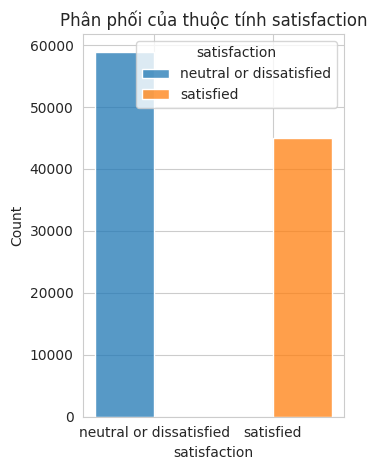

In [9]:
histogram(train_df[[target, "Class"]],
          hue=target,
          fig_size=None)

In [10]:
train_df[target].value_counts(ascending = False)

satisfaction
neutral or dissatisfied    58879
satisfied                  45025
Name: count, dtype: int64

Tập dữ liệu huấn luyện bị mất cân bằng nhẹ, với lớp neutral or dissatisfied (trung lập hoặc không hài lòng) có nhiều hơn 13854 mẫu.

Nhóm tiến hành kiểm tra xem tập dữ liệu kiểm tra có mẫu quan sát thiếu thuộc tính không:

In [11]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 25976 entries, 0 to 25975
Data columns (total 23 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Gender                             25976 non-null  object 
 1   Customer Type                      25976 non-null  object 
 2   Age                                25976 non-null  int64  
 3   Type of Travel                     25976 non-null  object 
 4   Class                              25976 non-null  object 
 5   Flight Distance                    25976 non-null  int64  
 6   Inflight wifi service              25976 non-null  int64  
 7   Departure/Arrival time convenient  25976 non-null  int64  
 8   Ease of Online booking             25976 non-null  int64  
 9   Gate location                      25976 non-null  int64  
 10  Food and drink                     25976 non-null  int64  
 11  Online boarding                    25976 non-null  int64  


Trên tập kiểm tra, thuộc tính Arrival Delay in Minutes có 83 mẫu thiếu dữ liệu. Nhóm cũng sẽ tiến hành loại bỏ các mẫu này khỏi tập kiểm tra.

## 1.1 Thống kê mô tả

In [12]:
train_df[num_features].describe()

,Age,Arrival Delay in Minutes,Baggage handling,Checkin service,Cleanliness,Departure Delay in Minutes,Departure/Arrival time convenient,Ease of Online booking,Flight Distance,Food and drink,Inflight entertainment,Inflight service,Inflight wifi service,Leg room service,On-board service,Online boarding,Seat comfort
count,103904.000000,103594.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000
mean,39.379706,15.178678,3.631833,3.304290,3.286351,14.815618,3.060296,2.756901,1189.448375,3.202129,3.358158,3.640428,2.729683,3.351055,3.382363,3.250375,3.439396
std,15.114964,38.698682,1.180903,1.265396,1.312273,38.230901,1.525075,1.398929,997.147281,1.329533,1.332991,1.175663,1.327829,1.315605,1.288354,1.349509,1.319088
min,7.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,31.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,27.000000,0.000000,3.000000,3.000000,2.000000,0.000000,2.000000,2.000000,414.000000,2.000000,2.000000,3.000000,2.000000,2.000000,2.000000,2.000000,2.000000
50%,40.000000,0.000000,4.000000,3.000000,3.000000,0.000000,3.000000,3.000000,843.000000,3.000000,4.000000,4.000000,3.000000,4.000000,4.000000,3.000000,4.000000
75%,51.000000,13.000000,5.000000,4.000000,4.000000,12.000000,4.000000,4.000000,1743.000000,4.000000,4.000000,5.000000,4.000000,4.000000,4.000000,4.000000,5.000000
max,85.000000,1584.000000,5.000000,5.000000,5.000000,1592.000000,5.000000,5.000000,4983.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000



**Nhận xét**:
1. Các thuộc tính số có độ lệch chuẩn cao, cho thấy miền giá trị ở các thuộc tính phân tán mạnh
2. Những thuộc tính có liên quan đến thời gian như Arrival Delay in Minutes, Departure Delay in Minutes có sự biến thiên mạnh: tứ phân vị thứ nhất và thứ hai bằng 0, rồi đột ngột tăng ở tứ phân vị thứ 3. Điều này cho thấy phần lớn các chuyến bay diễn ra đúng giờ, với một số ít chuyến bay gặp trục trặc về thời gian khởi hành hoặc thời gian máy bay đến.
3. Ở các thuộc tính đánh giá dịch vụ, hầu hết tứ phân vị thứ 2 và 3 lần lượt là 2 và 4. Điều này cho thấy phần lớn các dịch vụ được đánh giá ở mức trung bình, và điều này có thể ảnh hưởng đến chất lượng chuyến bay.

##1.2 Phân phối giá trị của các thuộc tính số

Nhóm tiến hành vẽ biểu đồ tần suất của các thuộc tính số không phải là thuộc tính đánh giá như Age, Flight Distance, Departure Delay in Minutes và Arrival Delay in Minutes để xem phân phối của chúng:

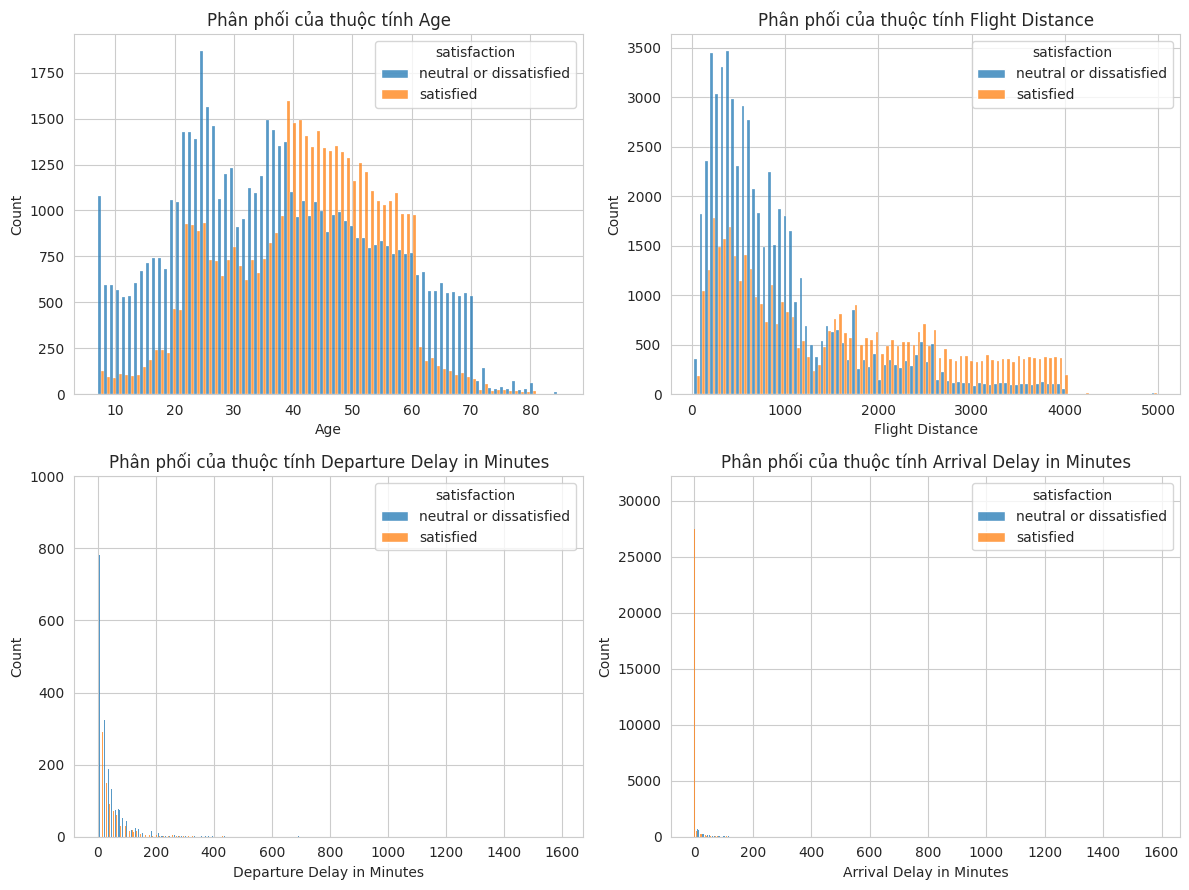

In [13]:
histogram(train_df[num_features_true + [target]],
          hue=target)

**Nhận xét**: Các thuộc tính có khoảng giá trị không giống nhau. Biểu đồ tần suất còn cho thấy các thuộc tính không có hình dáng của phân phối chuẩn, hơn nữa còn bị lệch (skewed) ở các thuộc tính Flight Distance, Arrival Delay in Minutes và Departure Delay in Minutes.

**Nhận xét chung**: Các thuộc tính số cần phải được co giãn nhằm tăng tốc quá trình huấn luyện mô hình.

#2.Chia dữ liệu

Chia tập huấn luyện gốc thành tập huấn luyện nhỏ hơn và tập kiểm định theo tỉ lệ 8:2. Tập huấn luyện nhỏ hơn được dùng để huấn luyện, còn tập kiểm đình được dùng để đánh giá mô hình, từ đó ta có thể điều chỉnh mô hình. Cần phải chia dữ liệu ngay từ đầu để tránh hiện tượng Dòm ngó dữ liệu (Data snooping). Hơn nữa, tập huấn luyện và tập kiểm định phải có phân phối giữa các lớp xấp xỉ giống phân phối ở tập huấn luyện gốc để ta có cơ sở đánh giá mô hình. Điều này có thể được thực hiện bằng phương pháp lấy mẫu stratified:

In [14]:
train_split_path = "/content/drive/MyDrive/Đồ án Học máy/Mã nguồn/Bộ dữ liệu/train_split.csv"
valid_split_path = "/content/drive/MyDrive/Đồ án Học máy/Mã nguồn/Bộ dữ liệu/valid_split.csv"

In [15]:
# Chia tập dữ liệu thành các tập huấn luyện (train) và kiểm định (valid) với tỉ lệ 80-20
spliter = StratifiedShuffleSplit(n_splits=1,
                                 test_size=0.2,
                                 random_state=SEED)

for train_index, valid_index in spliter.split(train_df, train_df[target]):
    valid_split_df = train_df.loc[valid_index]
    train_split_df = train_df.loc[train_index]

# saving the dataframes
train_split_df.to_csv(train_split_path)
valid_split_df.to_csv(valid_split_path)

'# Chia tập dữ liệu thành các tập huấn luyện (train) và kiểm định (valid) với tỉ lệ 80-20\nspliter = StratifiedShuffleSplit(n_splits=1,\n                                 test_size=0.2,\n                                 random_state=SEED)\n\nfor train_index, valid_index in spliter.split(train_df, train_df[target]):\n    valid_split_df = train_df.loc[valid_index]\n    train_split_df = train_df.loc[train_index]\n\n# saving the dataframes\ntrain_split_df.to_csv(train_split_path)\nvalid_split_df.to_csv(valid_split_path)'

In [16]:
#load train valid test sets
train_df = pd.read_csv(train_split_path,
                       index_col=0)
valid_df = pd.read_csv(valid_split_path,
                       index_col=0)

Xoá các mẫu thiếu thuộc tính Arrival Delay in Minutes trên tập huấn luyện, tập kiểm định và tập kiểm tra:

Số lượng mẫu trong tập huấn luyện: 82874
Số lượng mẫu trong tập kiểm định: 20720
Số lượng mẫu trong tập kiểm tra: 25893
Phân phối giữa nhãn dự cần dự đoán trong tập huấn luyện:


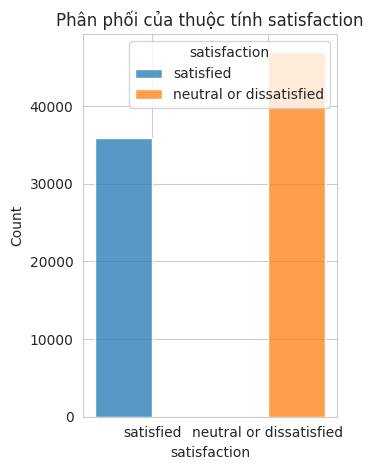

In [17]:
train_df = train_df.dropna(subset=["Arrival Delay in Minutes"])
valid_df = valid_df.dropna(subset=["Arrival Delay in Minutes"])
test_df = test_df.dropna(subset=["Arrival Delay in Minutes"])

# In số lượng các mẫu trong từng tập
print("Số lượng mẫu trong tập huấn luyện:", len(train_df))
print("Số lượng mẫu trong tập kiểm định:", len(valid_df))
print("Số lượng mẫu trong tập kiểm tra:", len(test_df))

print("Phân phối giữa nhãn dự cần dự đoán trong tập huấn luyện:")
histogram(train_df[[target, "Class"]],
          hue=target,
          fig_size=None)

#3.EDA

## 3.1 Phân phối giá trị của các thuộc tính số

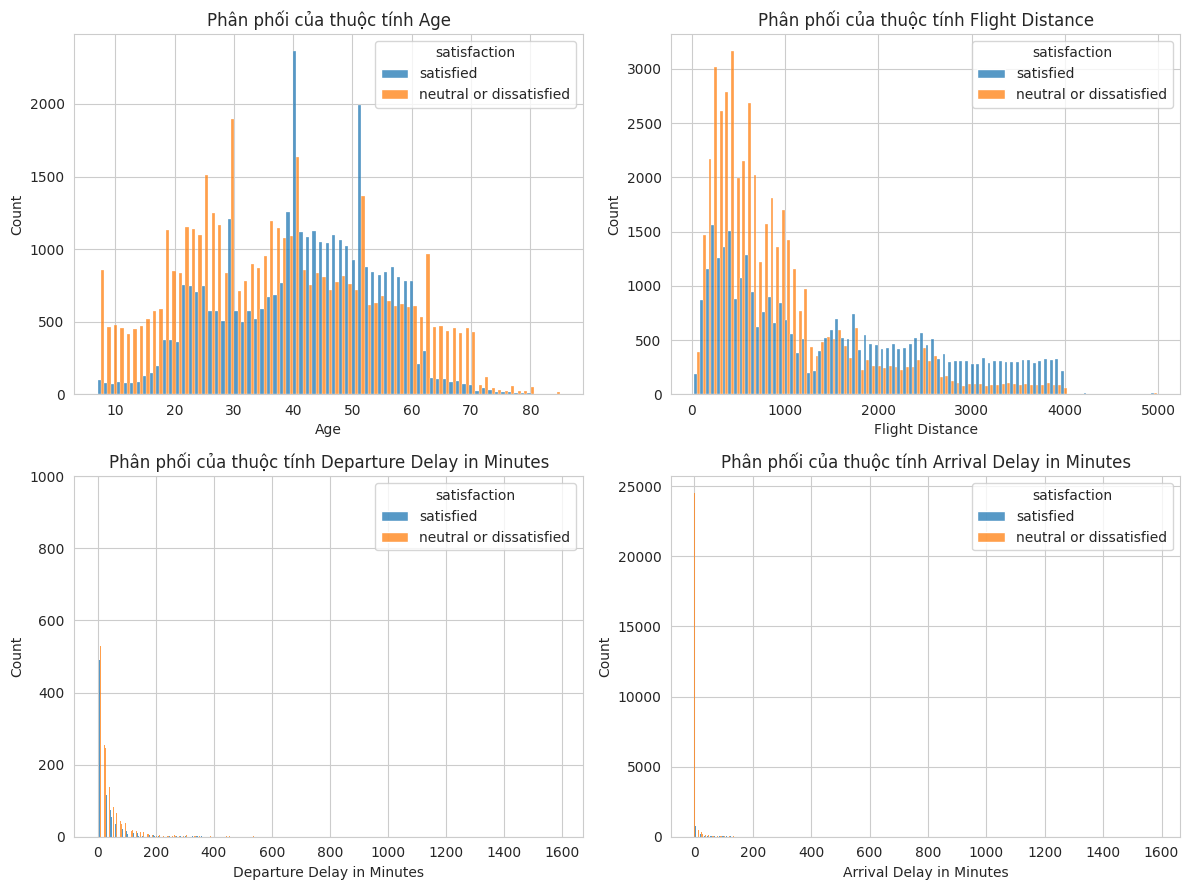

In [18]:
histogram(train_df[num_features_true + [target]],
          hue=target)

**Phân tích**: Các thuộc tính số không có hình dạng của phân phối chuẩn, hơn nữa có độ lệch (skewness) cao. Ngoài ra, ta cần co giãn miền giá trị của các thuộc tính số về khoảng nhỏ hơn nhằm tăng tốc quá trình huấn luyện mô hinh.

##3.2 Tương quan giữa các thuộc tính số

Nhóm tiến hành tính ma trận hệ số tương quan Pearson r giữa các cặp thuộc tính số trên tập huấn luyện

In [19]:
train_df_num = train_df[num_features].copy()
train_df_num_corr = train_df_num.corr()

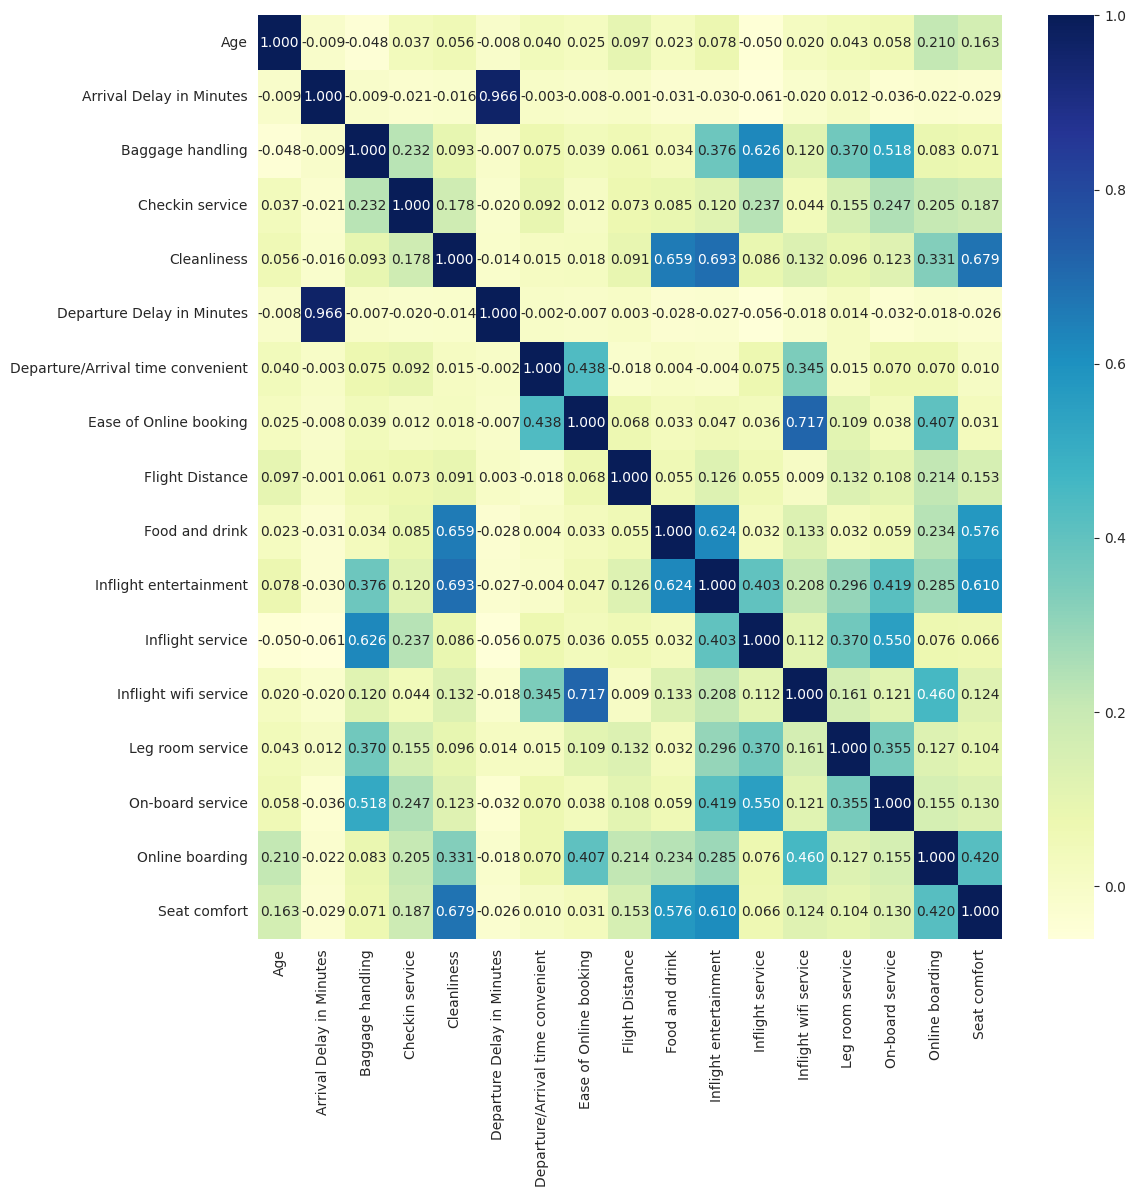

In [20]:
plt.figure(figsize = (12, 12))
sns.heatmap(train_df_num_corr,
            fmt=".3f",
            annot=True,
            cmap="YlGnBu")
plt.show()

**Nhận xét**: Các cặp thuộc tính sau có độ tương quan cao (hệ số tương quan nằm trong khoảng ±0.5 và ±1):
1. Departure Delay in Minutes - Arrival Delay in Minutes
2. Food and drink - Cleanliness
3. Food and drink - Seat comfort
4. Inflight entertainment - Cleanliness
5. Inflight entertainment - Food and drink
6. Inflight service - Baggage handling
7. Inflight service - On-board service
8. Inflight wifi service - Ease of Online Booking
9. On-board service - Baggage handling
10. Seat comfort - Cleanliness
11. Seat comfort - Inflight entertainment

Ta có thể chọn 1 cặp thuộc tính bất kì để vẽ biểu đồ phân tán nhằm quan sát rõ hơn về mối tương quan giữa hai thuộc tính. Nhóm chọn cặp thuộc tính số 1 để trực quan hoá:

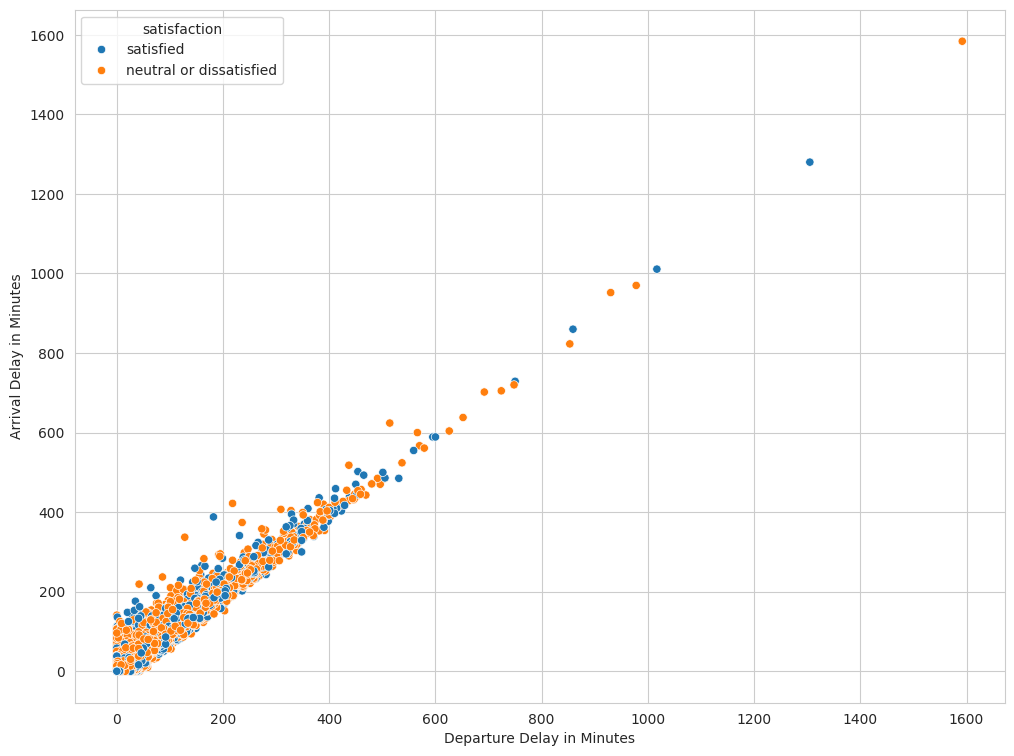

In [21]:
plt.figure(figsize=FIG_SIZE)
sns.scatterplot(x=train_df["Departure Delay in Minutes"],
                y=train_df["Arrival Delay in Minutes"],
                hue=train_df[target])
plt.show()

Từ việc quan sát các cặp thuộc tính tương quan mạnh, nhóm sẽ áp dụng PCA để giảm số lượng thuộc tính. Việc giảm số lượng thuộc tính có thể giúp các mô hình học máy tránh bị quá khớp.

#4.Tiền xử lý

## 4.1 Xử lý các thuộc tính số

**Co giãn miền giá trị các thuộc tính số và Phân tích thành phần chính**

Trước khi áp dụng PCA, các thuộc tính số cần được co giãn bằng phương pháp chuẩn tắc hoá (standardization) nhằm đưa các thuộc tính về phân phối có kì vọng bằng 0 và phương sai đơn vị. Sau khi co giãn, các thuộc tính số sẽ được áp dụng PCA với phương sai bảo toàn tối thiểu là 0.95:

In [22]:
pca = PCA(n_components=0.95, random_state=SEED)
num_pipeline = Pipeline([
    ("std_scaler", StandardScaler()),
    ("PCA", pca)
])
train_df_num = num_pipeline.fit_transform(train_df_num)
var_exp = pca.explained_variance_ratio_
cum_var_exp = np.cumsum(var_exp)

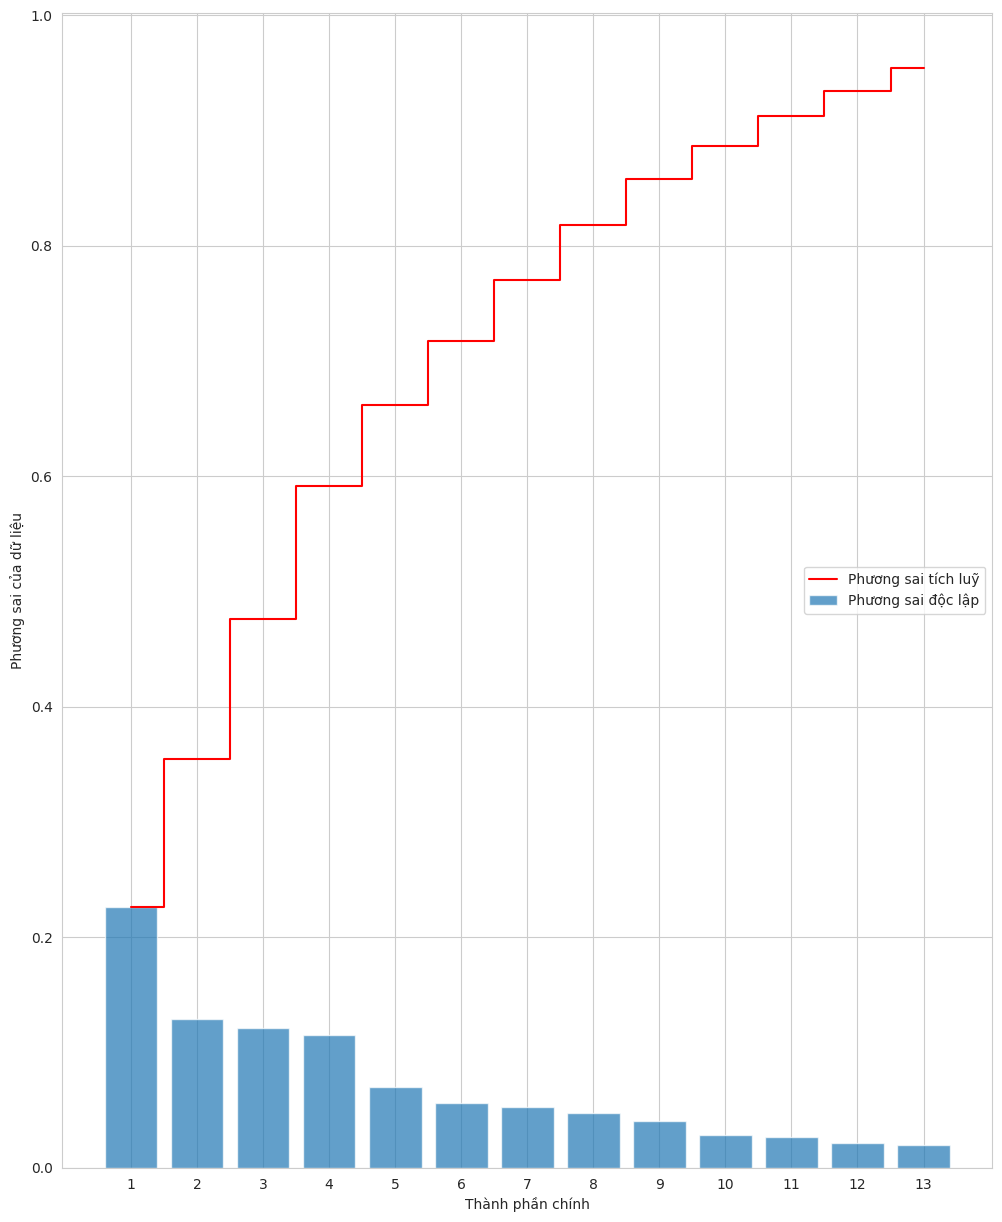

Phương sai tích luỹ đến thành phần chính thứ 1: 22.615%
Phương sai tích luỹ đến thành phần chính thứ 2: 35.492%
Phương sai tích luỹ đến thành phần chính thứ 3: 47.592%
Phương sai tích luỹ đến thành phần chính thứ 4: 59.134%
Phương sai tích luỹ đến thành phần chính thứ 5: 66.158%
Phương sai tích luỹ đến thành phần chính thứ 6: 71.761%
Phương sai tích luỹ đến thành phần chính thứ 7: 77.055%
Phương sai tích luỹ đến thành phần chính thứ 8: 81.772%
Phương sai tích luỹ đến thành phần chính thứ 9: 85.802%
Phương sai tích luỹ đến thành phần chính thứ 10: 88.639%
Phương sai tích luỹ đến thành phần chính thứ 11: 91.294%
Phương sai tích luỹ đến thành phần chính thứ 12: 93.469%
Phương sai tích luỹ đến thành phần chính thứ 13: 95.451%


In [23]:
plt.figure(figsize=(12, 15))
plt.bar(range(1,len(cum_var_exp)+1),
        var_exp,
        align='center',
        label='Phương sai độc lập',
        alpha=0.7)
plt.step(range(1,len(cum_var_exp)+1),
         cum_var_exp,
         where='mid',
         label='Phương sai tích luỹ',
         color='red')
plt.ylabel('Phương sai của dữ liệu')
plt.xlabel('Thành phần chính')
plt.xticks(np.arange(1,len(var_exp)+1,1))
plt.legend(loc='center right')
plt.show()

# Cumulative variance explained
for i, sum in enumerate(cum_var_exp):
    print(f"Phương sai tích luỹ đến thành phần chính thứ {str(i+1)}: {cum_var_exp[i]*100:.3f}%")

Hơn 95% phương sai của dữ liệu được bảo toàn với 13 thành phần đầu tiên của PCA. Nhóm sẽ dùng 13 thành phần chính này thay cho 17 thuộc tính số làm các thuộc tính mới.

Phân phối của các thuộc tính mới:


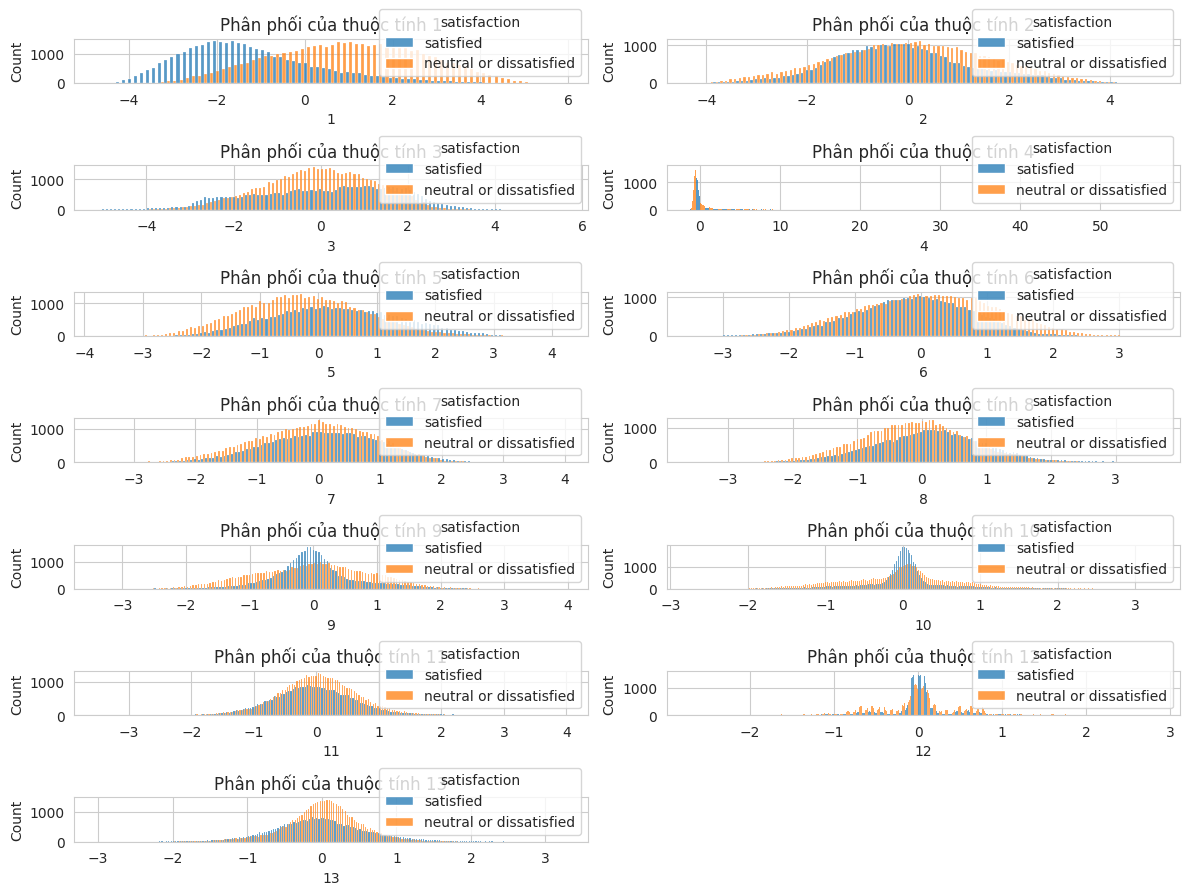

In [24]:
train_df_num = pd.DataFrame(train_df_num,
                            columns=list(range(1, 13+1)))
train_df_num_copy = train_df_num.copy()
train_df_num_copy[target] = list(train_df[target])
histogram(train_df_num_copy,
          hue=target)

**Nhận xét**: Hầu hết phân phối của các thành phần chính có dạng hình chuông (trừ thành phần chính thứ 3), có kì vọng gần 0 và khoảng giá trị gần giống nhau (trừ thành phần chính thứ 4). Nhóm tiến hành tái co giãn các thuộc tính mới bằng chuẩn tắc hoá (standardization). Việc co giãn thuộc tính có thể giúp một số mô hình học máy như SVC cho kết quả phân lớp tốt hơn.

In [25]:
train_df_num = train_df[num_features].copy()
pca = PCA(n_components=0.95, random_state=SEED)
num_pipeline = Pipeline([
    ("std_scaler", StandardScaler()),
    ("PCA", pca),
    ("std_scaler_after_pca", StandardScaler()),
])
train_df_num = num_pipeline.fit_transform(train_df_num)

Quan sát phân phối của các thuộc tính mới sau khi trải qua các bước xử lý thuộc tính số:

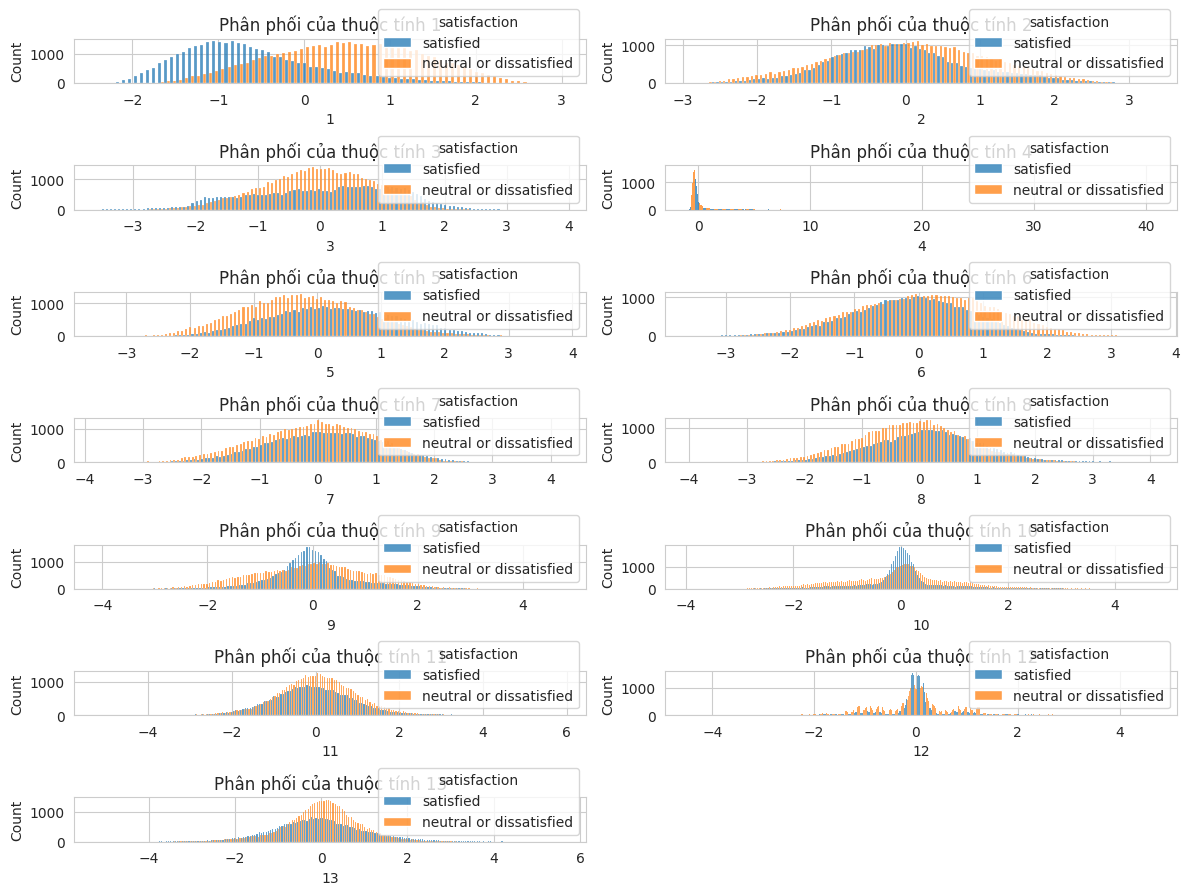

In [26]:
train_df_num = pd.DataFrame(train_df_num,
                            columns=list(range(1, 13+1)))
train_df_num_copy = train_df_num.copy()
train_df_num_copy[target] = list(train_df[target])
histogram(train_df_num_copy,
          hue=target)

##4.2 Xử lý các thuộc tính hạng mục

Nhóm biến đổi các thuộc tính hạng mục bằng mã hoá one-hot (one-hot encoding):

In [27]:
train_df_cat = train_df[cat_features].copy()
cat_encoder = OneHotEncoder()
train_df_cat = cat_encoder.fit_transform(train_df_cat)
print(train_df_cat.toarray()[:3])
print("Các hạng mục của từng thuộc tính hạng mục:")
cat_encoder.categories_

[[1. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 1. 0. 1. 0.]
 [1. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 1. 1. 0.]
 [0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 1.]]
Các hạng mục của từng thuộc tính hạng mục:


[array(['Business', 'Eco', 'Eco Plus'], dtype=object),
 array(['Loyal Customer', 'disloyal Customer'], dtype=object),
 array([0, 1, 2, 3, 4, 5]),
 array(['Female', 'Male'], dtype=object),
 array(['Business travel', 'Personal Travel'], dtype=object)]

Nhóm cũng mã hoá thuộc tính phân lớp. Vì mục tiêu là tạo một mô hình nhận diện các khách hàng không hài lòng với dịch vụ hàng không, nên nhóm mã hoá lớp "neutral or dissatisfied" thành True và "satisfied thành False

In [28]:
train_df_target = train_df[target].copy()
train_df_target = (train_df_target == "neutral or dissatisfied")
print(train_df_target[:3])

30633    False
98857     True
80498     True
Name: satisfaction, dtype: bool


## 4.3 Tổng hợp các bước tiền xử lý dữ liệu

In [29]:
X_train = train_df.drop(target, axis=1)
y_train = train_df[target].copy()
y_train = (y_train == "neutral or dissatisfied")

X_valid = valid_df.drop(target, axis=1)
y_valid = valid_df[target].copy()
y_valid = (y_valid == "neutral or dissatisfied")


X_test = test_df.drop(target, axis=1)
y_test = test_df[target].copy()
y_test = (y_test == "neutral or dissatisfied")

Pipeline tiền xử lý:

In [30]:
num_pipeline = Pipeline([
    ("std_scaler", StandardScaler()),
    ("PCA", PCA(n_components=0.95, random_state=SEED)),
    ("std_scaler_after_pca", StandardScaler()),
])
cat_pipeline = Pipeline([
    ("encoder", OneHotEncoder())
])

preprocess_pipeline = ColumnTransformer([
    ("num", num_pipeline, num_features),
    ("cat", cat_pipeline, cat_features)
])

Biến đổi dữ liệu trên tập huấn luyện, tập kiểm định và tập kiểm tra:

In [31]:
X_train = preprocess_pipeline.fit_transform(X_train)

X_valid= preprocess_pipeline.transform(X_valid)

X_test = preprocess_pipeline.transform(X_test)

Lưu pipeline tiền xử lý dữ liệu:

In [32]:
with open('/content/drive/MyDrive/Đồ án Học máy/Mã nguồn/Mô hình/preprocess_pipeline.pkl', 'wb') as file:
    pickle.dump(preprocess_pipeline, file)

# 5.Huấn luyện mô hình học máy

## 5.1 Mô hình

Nhóm sử dụng 3 mô hình sau: SVC, Logistic regression (Hồi quy logistic) và Random forest (Rừng ngẫu nhiên). Các mô hình được khai báo với các siêu tham số mặc định:

In [70]:
models = {
    "SVC": SVC(random_state=SEED),
    "Logistic regression": LogisticRegression(random_state=SEED),
    "Random forest": RandomForestClassifier(random_state=SEED)
}

## 5.2 Huấn luyện và đánh giá mô hình

Nhóm tiến hành huấn luyện 3 mô hình học máy trên tập huấn luyện và đánh giá trên tập kiểm định bằng binary cross entropy loss và chỉ số $\text{Recall}$. Chỉ số $\text{Recall}$ được sử dụng là vì nhóm muốn đánh giá liệu mô hình phân lớp có thể phát hiện chính xác khách hàng không hài lòng với dịch vụ hàng không hay không (khách hàng không hài lòng không bị phân loại nhầm thành khách hài lòng). Ngoài ra nhóm cũng sẽ sử dụng thêm chỉ số $\text{Accuracy}$ để đánh giá các mô hình.

In [71]:
metrics = {
    "recall": recall_score,
    "accuracy": accuracy_score,
}

In [72]:
def training(models,
             metrics):
    histories = {}

    for model_name, model in models.items():
        history = {}
        model.fit(X_train, y_train)
        y_pred_train = model.predict(X_train)
        y_pred_valid = model.predict(X_valid)

        for metric_name, metric in metrics.items():
            history[f"train {metric_name}"] = [round(metric(y_train, y_pred_train), 3)]
            history[f"val {metric_name}"] = [round(metric(y_valid, y_pred_valid), 3)]

        histories[f"{model_name}"] = history


    return models, histories

def print_results(histories):
    with pd.option_context('display.max_rows', None,
                           'display.max_columns', None,
                           'display.precision', 3):
        for i, (model_name, history) in enumerate(histories.items(), 1):
            print(f"Kết quả của mô hình {model_name}")
            print(pd.DataFrame(history).to_markdown())
            print("\n")

In [73]:
models, histories = training(models, metrics)

Kết quả của từng mô hình trên tập huấn luyện và kiếm định:

In [74]:
print_results(histories)

Kết quả của mô hình SVC
|    |   train recall |   val recall |   train accuracy |   val accuracy |
|---:|---------------:|-------------:|-----------------:|---------------:|
|  0 |          0.971 |        0.964 |            0.954 |          0.947 |


Kết quả của mô hình Logistic regression
|    |   train recall |   val recall |   train accuracy |   val accuracy |
|---:|---------------:|-------------:|-----------------:|---------------:|
|  0 |          0.905 |          0.9 |            0.873 |          0.874 |


Kết quả của mô hình Random forest
|    |   train recall |   val recall |   train accuracy |   val accuracy |
|---:|---------------:|-------------:|-----------------:|---------------:|
|  0 |              1 |        0.956 |                1 |          0.935 |




**Nhận xét**: Cả ba mô hình đều cho các chỉ số $\text{Recall}$ và $\text{Accuracy}$ tốt trên tập huấn luyện và kiểm định. Tuy vậy, Hồi quy logistic có thể cần được cải thiện thêm để có bias (độ lệch) thấp hơn.

## 5.3 Ensemble learning (Học kết hợp)

Từ các mô hình học máy trên, nhóm kết hợp lại thành một mô hình ensemble bằng phương pháp stacking. Đầu tiên, nhóm tiến hành cài đặt lớp EnsembleStackingClassifier:

In [75]:
class EnsembleStackingClassifier(ClassifierMixin, BaseEstimator):
    def __init__(self,
                 base_models,
                 meta_model):
        self.base_models = base_models
        self.meta_model = meta_model

    def _add_meta_features(self, X):
        # add new features
        X_new = X.copy()
        meta_features = []
        for model in self.base_models.values():
            pred = np.expand_dims(model.predict(X), axis=1)
            meta_features.append(pred)
        X_new = np.concatenate([X_new] + meta_features,
                               axis=1)
        return X_new

    def fit(self, X, y): #inputs are np arrays
        for model in self.base_models.values():
            model.fit(X, y)

        X_new = self._add_meta_features(X.copy())
        #train meta model
        self.meta_model.fit(X_new, y)

    def predict(self, X):
        X_new = self._add_meta_features(X.copy())
        y_pred = self.meta_model.predict(X_new)
        return y_pred

    def score(self, X, y,
              metrics,
              set_name="valid"):
        y_pred = self.predict(X)
        result = {} if metrics else None
        if metrics:
            for metric_name, metric in metrics.items():
                result[f"{set_name} {metric_name}"] = [round(metric(y, y_pred), 3)]

        return result

Để sử dụng mô hình ensemble, trước tiên cần định nghĩa các base estimator và meta model. Nhóm sử dụng 3 mô hình SVC, Hồi quy logistic và Random forest như đã trình bày làm các base estimator. Meta model nhóm sử dụng là SVC:

In [76]:
base_models = {
    "SVC": SVC(random_state=SEED),
    "Logistic regression": LogisticRegression(random_state=SEED),
    "Random forest": RandomForestClassifier(random_state=SEED)
}
meta_model = SVC(random_state=SEED)
ensemble = EnsembleStackingClassifier(base_models=base_models,
                                      meta_model=meta_model)

Nhóm tiến hành huấn luyện mô hình, sau đó đánh giá các chỉ số trên tập huấn luyện và tập kiểm định:

In [77]:
ensemble, history = training({"Stacking ensemble": ensemble}, metrics)
print_results(history)
ensemble = ensemble['Stacking ensemble']

Kết quả của mô hình Stacking ensemble
|    |   train recall |   val recall |   train accuracy |   val accuracy |
|---:|---------------:|-------------:|-----------------:|---------------:|
|  0 |              1 |        0.956 |                1 |          0.935 |




**Nhận xét**: Mô hình cho các kết quả trên tập huấn luyện và kiểm định tốt. Tuy nhiên có thể thấy rằng kết quả phân lớp của mô hình ensemble tương đồng với kết quả của mô hình Random forest. Điều này có thể là do Random forest đang là base estimator tốt nhất trên tập huấn luyện, nên meta model sẽ

Lưu mô hình ensemble:

In [83]:
with open("/content/drive/MyDrive/Đồ án Học máy/Mã nguồn/Mô hình/ensemble_classifier.pkl", "wb") as file:
    pickle.dump(ensemble, file)

## 5.4 Deep learning (Học sâu)

Mô hình học sâu nhóm sử dụng cho bài toán phân loại nhị phân là mạng dense 6 tầng ẩn, mỗi tầng ẩn dùng hàm kích hoạt ReLU. Tầng ẩn thứ hai và thứ tư được áp dụng dropout với tỉ lệ là 0.2. Kiến trúc mô hình được mô tả ở bảng dưới đây:

In [42]:
def get_dnn(input_shape):
    model = keras.Sequential([
        #--phase 1--
        keras.layers.Dense(units=64,
                           input_shape=input_shape,
                          activation="relu"),
        keras.layers.Dense(units=64,
                           activation="relu"),
        keras.layers.Dropout(rate=0.2),

        #--phase 2--
        keras.layers.Dense(units=128,
                           activation="relu"),
        keras.layers.Dense(units=128,
                           activation="relu"),
        keras.layers.Dropout(rate=0.2),

        #--phase 3--
        keras.layers.Dense(units=256,
                           activation="relu"),
        keras.layers.Dense(units=256,
                           activation="relu"),

        #--output--
        keras.layers.Dense(units=1,
                           activation="sigmoid"),
    ])
    return model
model = get_dnn(input_shape=(X_train.shape[1],))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                1856      
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 128)               8320      
                                                                 
 dense_3 (Dense)             (None, 128)               16512     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_4 (Dense)             (None, 256)               3

Nhóm tiến hành huấn luyện mô hình với hàm loss entropy nhị phân và bộ tối ưu NAdam, tốc độ học khởi tạo mặc định là 0.001 (không sử dụng kỹ thuật suy giảm tốc độ học), kích thước batch là 64 và số epoch huấn luyện là 100. Mô hình được đánh giá bằng tập kiểm định với các chỉ số $\text{Recall}$ và $\text{Accuracy}$. Ngoài ra, nhóm cũng sử dụng kỹ thuật dừng sớm (early stopping) dựa trên $\text{Recall}$ trên tập kiểm định:

In [89]:
model.compile(optimizer='nadam',
              loss='binary_crossentropy',
              metrics=[keras.metrics.Recall(name="recall"), 'accuracy'])

In [76]:
early_stopping = keras.callbacks.EarlyStopping(monitor='val_recall',
                                               mode="max",
                                               patience=10,
                                               restore_best_weights=True)
history = model.fit(X_train, y_train,
                    validation_data=(X_valid, y_valid),
                    epochs=100,
                    batch_size=64,
                    callbacks=[early_stopping],
                    verbose=1)

Epoch 1/100
1295/1295 [==============================] - 17s 8ms/step - loss: 0.2316 - recall: 0.9425 - accuracy: 0.9072 - val_loss: 0.1590 - val_recall: 0.9485 - val_accuracy: 0.9353
Epoch 2/100
1295/1295 [==============================] - 11s 9ms/step - loss: 0.1566 - recall: 0.9574 - accuracy: 0.9365 - val_loss: 0.1358 - val_recall: 0.9609 - val_accuracy: 0.9431
Epoch 3/100
1295/1295 [==============================] - 13s 10ms/step - loss: 0.1380 - recall: 0.9651 - accuracy: 0.9445 - val_loss: 0.1268 - val_recall: 0.9750 - val_accuracy: 0.9464
Epoch 4/100
1295/1295 [==============================] - 11s 9ms/step - loss: 0.1297 - recall: 0.9691 - accuracy: 0.9475 - val_loss: 0.1211 - val_recall: 0.9614 - val_accuracy: 0.9491
Epoch 5/100
1295/1295 [==============================] - 9s 7ms/step - loss: 0.1230 - recall: 0.9700 - accuracy: 0.9496 - val_loss: 0.1215 - val_recall: 0.9775 - val_accuracy: 0.9487
Epoch 6/100
1295/1295 [==============================] - 12s 9ms/step - loss: 0.

Sau khi huấn luyện mô hình, nhóm thu được đồ thị học như sau:

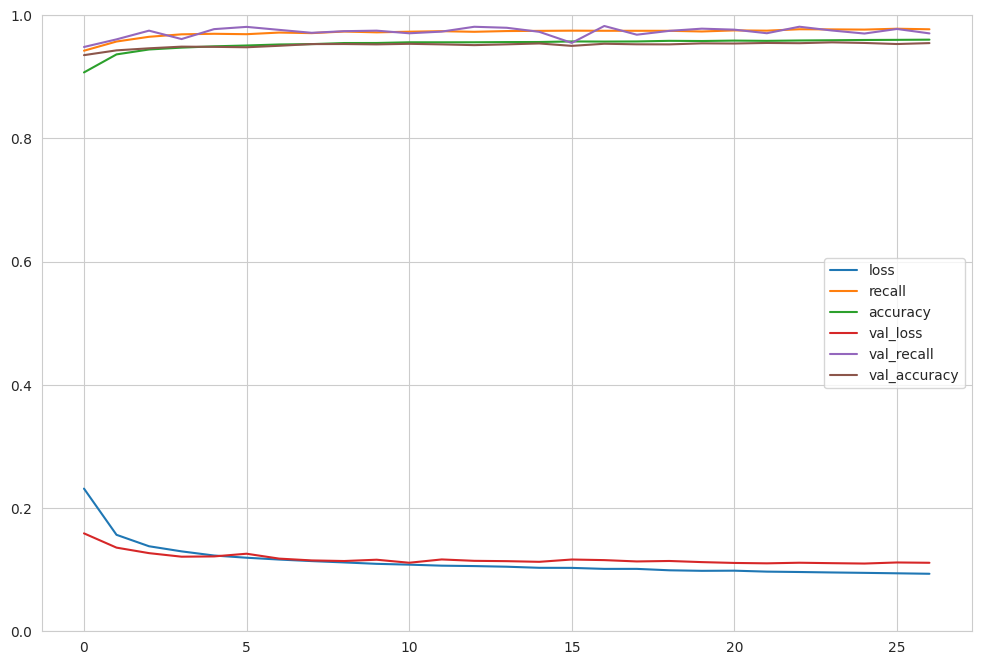

In [77]:
pd.DataFrame(history.history).plot(figsize=(12, 8))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

Từ đồ thị quá trình học, nhóm thấy rằng mô hình đã dừng sớm ở epoch 27. Nhóm cũng nhận thấy rằng quá trình huấn luyện diễn ra ổn định: loss trên tập huấn luyện và kiểm định giảm đều và sát nhau, cũng như các chỉ số $\text{Recall}$ và $\text{Accuracy}$ tăng đều và sát nhau.

Kết quả thu được của mô hình sau khi đã huấn luyện trên tập huấn luyện và tập kiểm định:

In [82]:
train_loss, train_recall, train_acc = model.evaluate(X_train, y_train)
val_loss, val_recall, val_acc = model.evaluate(X_valid, y_valid)
history = {
    "DNN": {
        "train loss": [train_loss],
        "val loss": [val_loss],
        "train recall": [train_recall],
        "val recall": [val_recall],
        "train accuracy": [train_acc],
        "val accuracy": [val_acc]
    }
}
print_results(history)

648/648 [==============================] - 3s 4ms/step - loss: 0.1155 - recall: 0.9826 - accuracy: 0.9538
Kết quả của mô hình DNN
|    |   train loss |   val loss |   train recall |   val recall |   train accuracy |   val accuracy |
|---:|-------------:|-----------:|---------------:|-------------:|-----------------:|---------------:|
|  0 |    0.0941131 |   0.115526 |       0.988203 |     0.982619 |         0.959565 |       0.953764 |




**Nhận xét**: So với 3 mô hình học máy truyền thống đã được huấn luyện, mạng neuron sâu cho các kết quả tốt trên tập huấn luyện và kiểm định và chúng rất gần nhau. Điều này cho thấy mô hình có khả năng mô hình hoá dữ liệu tốt mà không bị quá khớp trên tập huấn luyện.

Sau khi huấn luyện, nhóm tiến hành lưu lại mô hình:

In [83]:
save_path = "/content/drive/MyDrive/Đồ án Học máy/Mã nguồn/Mô hình"
model_path = os.path.join(save_path,
                          f"dnn model: val recall {val_recall:.4f}.weights.h5")
model.save_weights(model_path)

## 5.5 Kết quả thu được trên tập kiểm tra

5.5.1 Mô hình SVC, Random forest và Logistic regression

In [79]:
models_results = {}
for model_name, model in models.items():
    model_results = {}
    y_pred_test = model.predict(X_test)
    for metric_name, metric in metrics.items():
        model_results[f"test {metric_name}"] = [round(metric(y_test, y_pred_test), 3)]
    models_results[f"{model_name}"] = model_results

print_results(models_results)

Kết quả của mô hình SVC
|    |   test recall |   test accuracy |
|---:|--------------:|----------------:|
|  0 |         0.964 |           0.947 |


Kết quả của mô hình Logistic regression
|    |   test recall |   test accuracy |
|---:|--------------:|----------------:|
|  0 |           0.9 |            0.87 |


Kết quả của mô hình Random forest
|    |   test recall |   test accuracy |
|---:|--------------:|----------------:|
|  0 |         0.955 |           0.936 |




5.5.2 Mô hình Ensemble Stacking

In [85]:
ensemble_test_results = {
    "Stacking ensemble": ensemble.score(X_test, y_test,
                                        set_name="test",
                                        metrics=metrics)
}
print_results(ensemble_test_results)

Kết quả của mô hình Stacking ensemble
|    |   test recall |   test accuracy |
|---:|--------------:|----------------:|
|  0 |         0.955 |           0.936 |




5.5.3 Mạng neuron sâu

In [90]:
_, test_recall, test_acc = model.evaluate(X_test, y_test)
dnn_test_results = {
    "DNN": {
        "train recall": [test_recall],
        "train accuracy": [test_acc],
    }
}
print_results(dnn_test_results)

810/810 [==============================] - 3s 3ms/step - loss: 0.1129 - recall: 0.9827 - accuracy: 0.9550
Kết quả của mô hình DNN
|    |   train recall |   train accuracy |
|---:|---------------:|-----------------:|
|  0 |       0.982654 |         0.954969 |




**NHẬN XÉT CHUNG**: Các mô hình đều cho các chỉ số đánh giá tốt trên tập kiểm tra. Mô hình có kết quả tốt nhất ở cả hai chỉ số là mạng neuron sâu, kết tiếp là SVC, Stacking ensemble , Random forest và Hồi quy logistic. Tuy nhiên, mô hình Stacking ensemble đang cho kết quả giống hệt như Random forest. Điều này cho thấy mô hình ensemble đang chủ yếu dựa vào kết quả phân lớp của Random forest, trong khi đó các kết quả của SVC trên tập kiểm tra lại tốt hơn nhiều. Đây là điểm hạn chế của nhóm, và để giải quyết triệt để thì cần thực hiện các bước hiệu chỉnh (fine tuning) Random forest để mô hình không bị quá khớp trên tập huấn luyện.